# Detecting COVID-19 with Chest X Ray using PyTorch

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

Image classification: normal, viral pneumonia, covid

# Libraries

In [56]:
%matplotlib inline
from PIL import Image
from matplotlib import pyplot as plt

import os
import shutil
import random
import torch
import torchvision
import numpy as np



torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.13.0


# Preparing Training and Test Sets

In [109]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Dataset'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [110]:
class XRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [i for i in os.listdir(image_dirs[class_name]) if i.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images 
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for x in self.class_names:
            self.images[x] = get_images(x)
            
        self.image_dirs = image_dirs 
        self.transform = transform 
    
    def __len__(self):
        return sum([len(self.images[x]) for x in self.class_names])
    
    #fewer egs in covid class so pick random index, avoid out of bounds index vals 
    def __getitem__(self,index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        #RGB not channel 1 
        image = Image.open(image_path).convert('RGB')
        #transform to tensors
        return self.transform(image),self.class_names.index(class_name)

# Image Transformations

In [111]:
#create 2 transformed objects: 1 for training, 1 for test
#training object 
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(227, 227)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    #use resnet-18 pretrained weights 
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std=[0.229,0.224,0.225])
])
#test object 
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(227, 227)),
    torchvision.transforms.ToTensor(),
    #use resnet-18 pretrained weights 
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                    std=[0.229,0.224,0.225])
])

# Prepare DataLoader

In [112]:
train_dirs = {
    'normal': 'COVID-19 Radiography Dataset/normal',
    'viral': 'COVID-19 Radiography Dataset/viral',
    'covid': 'COVID-19 Radiography Dataset/covid'
}

train_dataset = XRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [113]:
test_dirs = {
    'normal': 'COVID-19 Radiography Dataset/test/normal',
    'viral': 'COVID-19 Radiography Dataset/test/viral',
    'covid': 'COVID-19 Radiography Dataset/test/covid'
}

test_dataset = XRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [114]:
#create data loader 
batch_size = 6 

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('# of training batches', len(dl_train))
print('# of test batches', len(dl_test))

# of training batches 2511
# of test batches 15


# Data Visualization

In [115]:
class_names = train_dataset.class_names 

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1,6, i+1, xticks=[], yticks=[])
        #plt.subplot(1,6, i+1)
        #bc channel first 
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean 
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()
    

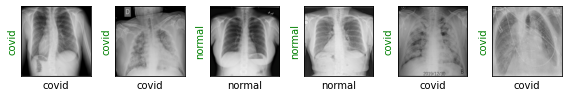

In [116]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

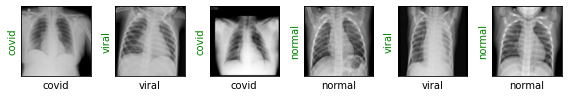

In [117]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [118]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [119]:
#looking at argpool above, w 1000 features, linear 
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)


In [120]:
def show_preds(): 
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

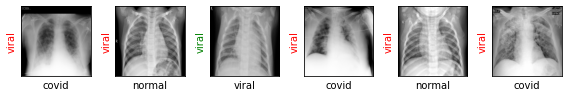

In [121]:
show_preds()

# Training the Model

In [122]:
def train(epochs): 
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0 
        
        resnet18.train() 
        
        for train_step, (images,labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            #back propogation 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #eval every 20 steps
            if train_step % 20 == 0: 
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    #1 = values, 0 = # of examples
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                acc = acc/ len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: { acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95: 
                    print('Performance over 95%')
                    return
                
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.4534, Acc: 0.3444


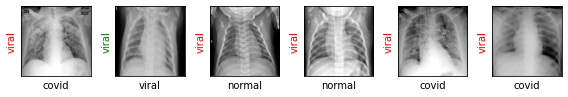

Evaluating at step 20
Val loss: 1.2896, Acc: 0.4667


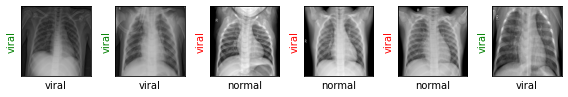

Evaluating at step 40
Val loss: 1.1555, Acc: 0.6000


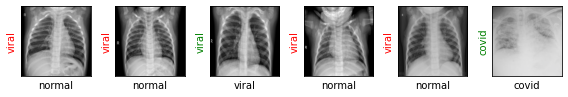

Evaluating at step 60
Val loss: 0.3754, Acc: 0.9333


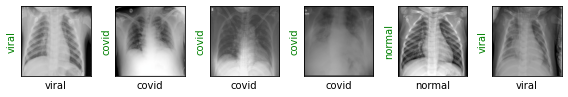

Evaluating at step 80
Val loss: 0.4744, Acc: 0.8333


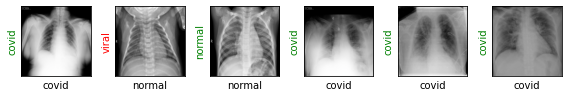

Evaluating at step 100
Val loss: 0.2824, Acc: 0.9111


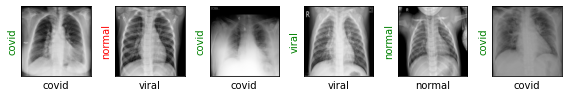

Evaluating at step 120
Val loss: 0.2145, Acc: 0.9556


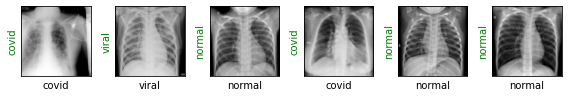

Performance over 95%


In [123]:
train(epochs = 1)

# Final Results

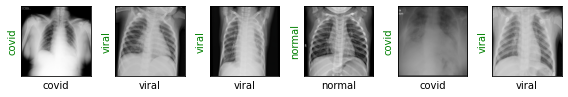

In [124]:
show_preds()